# 02 — K-Means (+ K-Medoids)
Baseline partícionáló klaszterezés több adatkészleten.
- K-Means: gyors, gömbszerű klaszterekhez ideális.
- K-Medoids: robusztusabb outlierekre (sklearn-extra).
A végén CSV-be mentjük a metrikákat.


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from src.datasets import make_all_datasets
from src.evaluation import evaluate
from src.visualization import pca_scatter

datasets = make_all_datasets()
list(datasets.keys())

ModuleNotFoundError: No module named 'src.algorithms'

In [ ]:
def pca_scatter(X, labels, title):
    Xs = StandardScaler().fit_transform(X)
    Xp = PCA(n_components=2, random_state=42).fit_transform(Xs)
    plt.figure(figsize=(6,5))
    plt.scatter(Xp[:,0], Xp[:,1], s=10, c=labels, cmap="viridis")
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout(); plt.show()

def silhouette_curve_for_kmeans(X, k_range=range(2, 11)):
    Xs = StandardScaler().fit_transform(X)
    scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init='auto', random_state=42)
        labels = km.fit_predict(Xs)
        m = evaluate(Xs, labels)  # -> {'sil','db','ch'}
        scores.append((k, m["sil"]))
    ks, vals = zip(*scores)
    plt.figure(figsize=(6,3.5))
    plt.plot(ks, vals, marker="o")
    plt.title("K-Means — Silhouette vs k")
    plt.xlabel("k"); plt.ylabel("silhouette")
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
    return pd.DataFrame(scores, columns=["k","silhouette"])


In [ ]:
def run_on_dataset(name, X, k):
    Xs = StandardScaler().fit_transform(X)

    # --- K-Means ---
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels_km = km.fit_predict(Xs)
    m_km = evaluate(Xs, labels_km)  # {'sil','db','ch'}
    pca_scatter(X, labels_km, f"{name} — KMeans k={k} (sil={m_km['sil']:.3f})")

    rows = [{"dataset": name, "algo": "kmeans", "k": k, **m_km}]

    # --- K-Medoids ---
    kmd = KMedoids(n_clusters=k, random_state=42)
    labels_kmd = kmd.fit_predict(Xs)
    m_kmd = evaluate(Xs, labels_kmd)
    pca_scatter(X, labels_kmd, f"{name} — KMedoids k={k} (sil={m_kmd['sil']:.3f})")

    rows.append({"dataset": name, "algo": "kmedoids", "k": k, **m_kmd})

    return rows

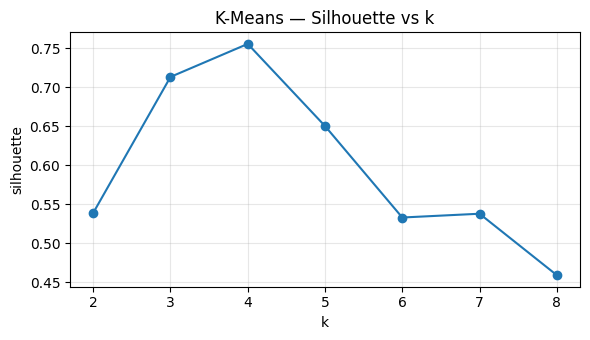

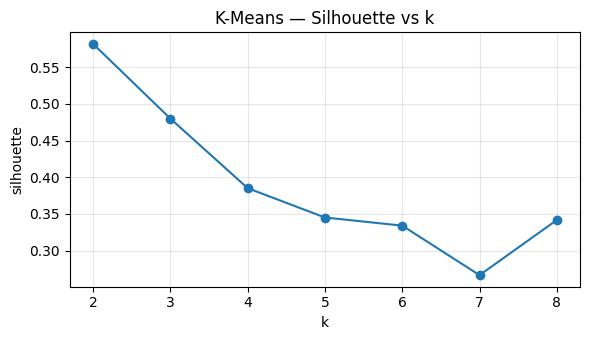

,k,silhouette
0,2,0.538935
1,3,0.713328
2,4,0.755672
3,5,0.650352
4,6,0.533062
5,7,0.537908
6,8,0.459143


,k,silhouette
0,2,0.581750
1,3,0.479881
2,4,0.385045
3,5,0.345033
4,6,0.333943
5,7,0.266429
6,8,0.341629


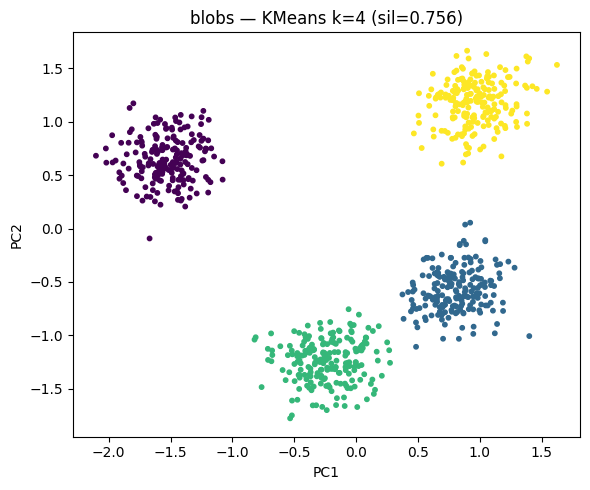

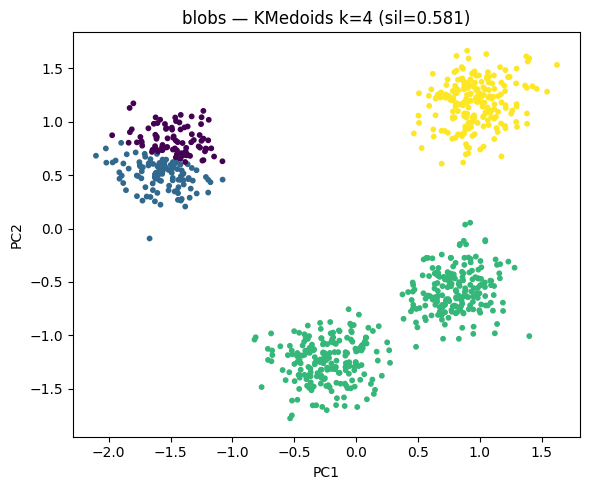

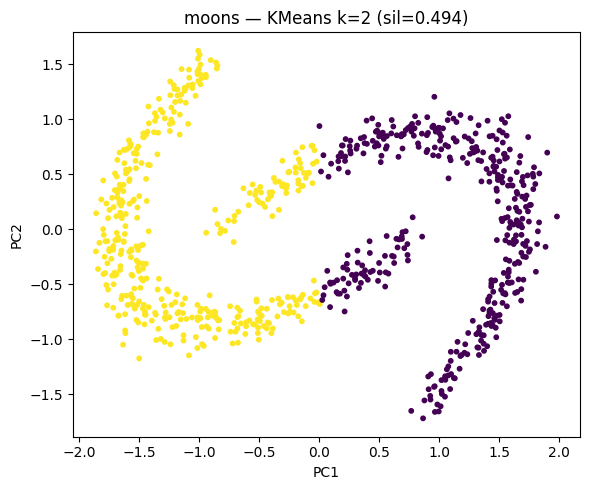

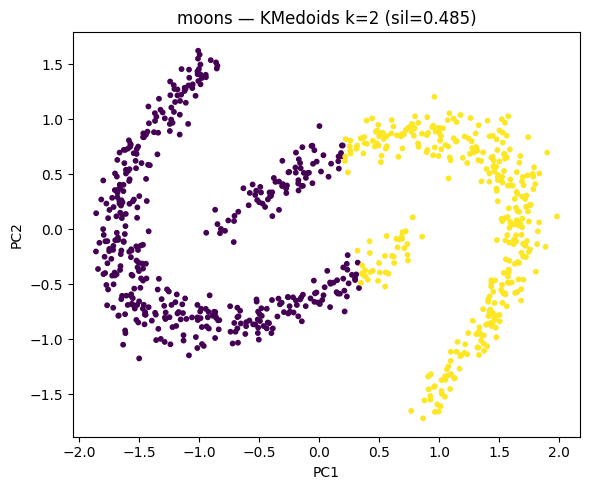

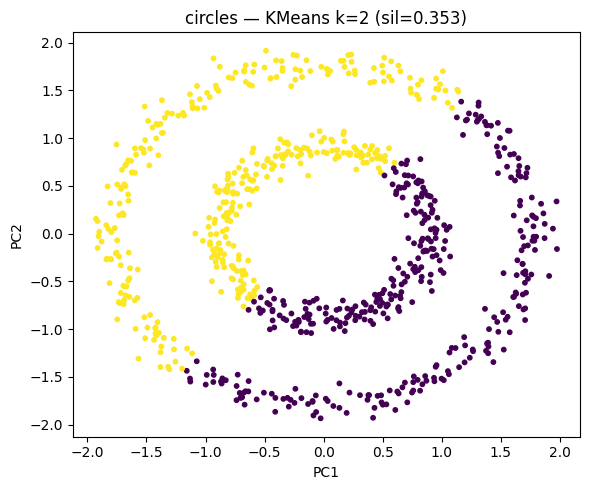

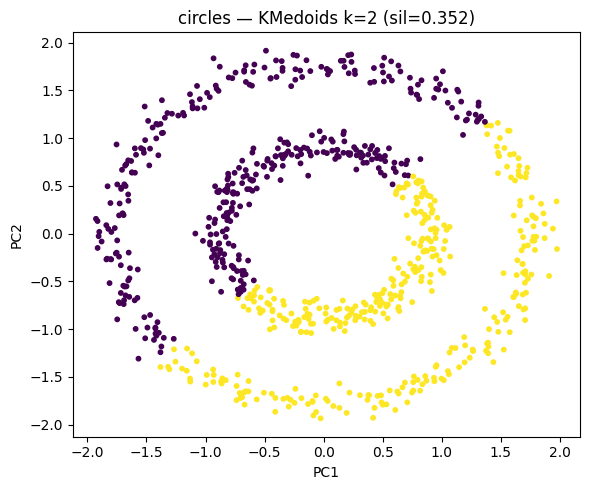

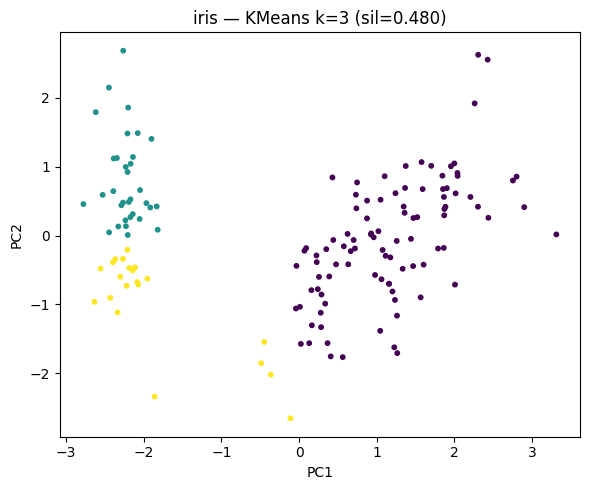

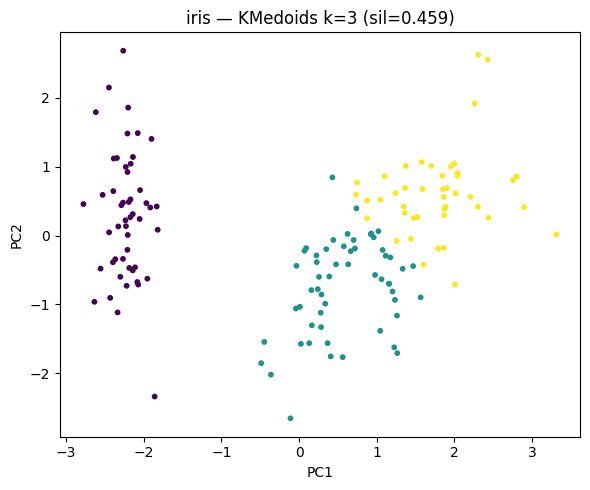

,dataset,algo,k,sil,db,ch
0,blobs,kmeans,4,0.755672,0.339428,5937.966481
1,blobs,kmedoids,4,0.581410,0.787534,1712.667532
2,moons,kmeans,2,0.494269,0.810828,1111.567362
3,moons,kmedoids,2,0.485252,0.818195,1061.468037
4,circles,kmeans,2,0.352557,1.186661,457.337747
5,circles,kmedoids,2,0.352013,1.187685,455.687500
6,iris,kmeans,3,0.479881,0.789363,157.360153
7,iris,kmedoids,3,0.459042,0.838455,239.748268


In [ ]:
# 5.1 — (opcionális) sil-görbe blobs + iris esetén
sil_blobs = silhouette_curve_for_kmeans(datasets["blobs"][0], range(2, 9))
sil_iris  = silhouette_curve_for_kmeans(datasets["iris"][0],  range(2, 9))
display(sil_blobs)
display(sil_iris)

# 5.2 — k értékek (praktikus plan)
plan = {
    "blobs":   4,
    "moons":   2,
    "circles": 2,
    "iris":    3,
}

all_rows = []
for name, (X, y, k) in datasets.items():
    k = plan[name]
    all_rows += run_on_dataset(name, X, k)

df = pd.DataFrame(all_rows)
display(df)

project_root = os.path.abspath("..")
os.makedirs(os.path.join(project_root, "results", "tables"), exist_ok=True)
out_path = os.path.join(project_root, "results", "tables", "kmeans_kmedoids.csv")

df.to_csv(out_path, index=False)